In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import invgauss
from sklearn import metrics

In [2]:
# Define generative simulation parameters
nsamples = 1000

In [3]:
# Define sensitivity of observer
dprime = 1.0
mu = [-dprime/2,dprime/2]
sigma = 1.0


In [4]:
# Define Type 1 bias of observer & Type 2 confidence criteria
c = 0.0
c2 = [.5, .75, 1.25]

In [5]:
# Define generative model space for graphical depiction
x = np.arange(-4,4,.01)
S1norm = norm.pdf(x,loc=mu[0],scale=sigma)
S2norm = norm.pdf(x,loc=mu[1],scale=sigma)


In [6]:
# Draw samples from each distribution
S1 = np.random.normal(mu[0],sigma,nsamples)
S2 = np.random.normal(mu[1],sigma,nsamples)
allSamples = np.hstack((S1,S2))
correctAnswer = np.hstack((np.zeros(nsamples),np.ones(nsamples)))


In [7]:
# Make the observer make decisions
choice = np.asarray(allSamples > c,dtype=np.float)
correct = np.asarray(choice==correctAnswer)

In [8]:
# Assign confidence to each decision too
confidence = np.zeros((nsamples*2,))
for t in range(0,nsamples*2):
    for i in (0,3):
        if np.abs(allSamples[t]) > c2[2]:
            confidence[t] = 3.0
        elif np.abs(allSamples[t]) > c2[1]:
            confidence[t] = 2.0
        elif np.abs(allSamples[t]) > c2[0]:
            confidence[t] = 1.0
        else:
            confidence[t] = 0

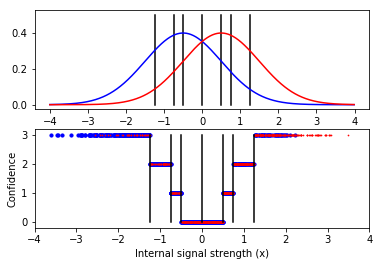

In [9]:
# Plot the samples and their confidence, underneath a schematic of the SDT generative model
Figure1, ax = plt.subplots(2,1)
plt.subplot(2,1,1)
plt.plot([c,c],[0,.5],'k')
for i in range(0,3):
    plt.plot([c2[i],c2[i]],[0,.5],'k')
    plt.plot([-c2[i],-c2[i]],[0,.5],'k')
plt.plot(x,S1norm,'b')
plt.plot(x,S2norm,'r')

plt.subplot(2,1,2)
plt.plot([c,c],[0,3],'k')
for i in range(0,3):
    plt.plot([c2[i],c2[i]],[0,3],'k')
    plt.plot([-c2[i],-c2[i]],[0,3],'k')
plt.scatter(S1,confidence[:nsamples],10,'b')
plt.scatter(S2,confidence[nsamples:],.5,'r')
plt.xlim([-4,4])
plt.xlabel('Internal signal strength (x)')
plt.ylabel('Confidence')

In [10]:
# Now let's actually calculate the d' and c and see how well our simulation matches our specified inputs
# How would this change if you drew fewer samples?

# First we need to define hits and false alarms
hits = np.asarray(np.asarray(correctAnswer==1) & np.asarray(choice==1),dtype=np.float)
fas = np.asarray(np.asarray(correctAnswer==0) & np.asarray(choice==1),dtype=np.float)

HR = sum(hits) / nsamples
FAR = sum(fas) / nsamples

# Question: how would you define correct rejections and misses?

# Now use the definition of d' and c to check
dprime_hat = norm.ppf(HR) - norm.ppf(FAR)
print "Estimated d' = ", dprime_hat 
c_hat = -0.5 * (norm.ppf(HR) + norm.ppf(FAR))
print "Estimated c = ", c_hat 


Estimated d' =  1.051993094
Estimated c =  -0.0244691480212


Type 1 AUC =  0.757471
Type 2 AUC =  0.636234671395


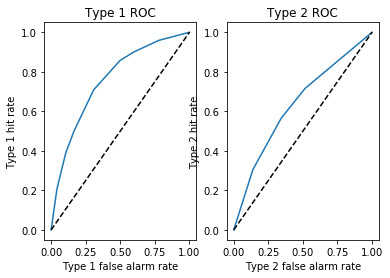

In [11]:
# Now we estimate the Type 2 sensitivity, as area under the Type 2 ROC, and compare to the area under the Type 1 ROC

# Construct the Type 1 ROC according to standard signal detection theoretic definitions, by "sweeping through" 
# the criterion options and calculation of hit and false alarm rates at each
c1 = np.hstack((-np.flipud(c2),c,c2))

HR1 = [1]
FAR1 = [1]
for i,cc in enumerate(c1):
    choice1 = np.asarray(allSamples > cc,dtype=np.float)
    hits1 = np.asarray(np.asarray(correctAnswer==1) & np.asarray(choice1==1),dtype=np.float)
    fas1 = np.asarray(np.asarray(correctAnswer==0) & np.asarray(choice1==1),dtype=np.float)
    HR1.append(sum(hits1) / nsamples)
    FAR1.append(sum(fas1) / nsamples)
HR1.append(0)
FAR1.append(0)

fig,ax = plt.subplots(1,2)
plt.subplot(1,2,1)
plt.plot(FAR1,HR1)
plt.xlabel('Type 1 false alarm rate')
plt.ylabel('Type 1 hit rate')
plt.plot([0,1],[0,1],'k--')
plt.title('Type 1 ROC')

# Calculate the area under the Type 1 ROC (AUC) as another measure of sensitivity
# Remember, chance AUC = 0.5 and perfect AUC = 1.0
AUC1 = metrics.auc(FAR1,HR1)
print "Type 1 AUC = ", AUC1
    
    
# To construct the Type 2 ROC, we need to redefine hits and false alarms in Type 2 space
# A Type 2 hit is "correct and high confidence" and a Type 2 false alarm is "incorrect and high confidence"

ncorrect = sum(np.asarray(correct==1))
nincorrect = sum(np.asarray(correct==0))

HR2 = [1]
FAR2 = [1]
for i in range(0,4):
    hits2 = np.asarray(np.asarray(correct==1) & np.asarray(confidence>i),dtype=np.float)
    fas2 = np.asarray(np.asarray(correct==0) & np.asarray(confidence>i),dtype=np.float)
    HR2.append(sum(hits2) / ncorrect)
    FAR2.append(sum(fas2) / nincorrect)
HR2.append(0)
FAR2.append(0)

plt.subplot(1,2,2)
plt.plot(FAR2,HR2)
plt.xlabel('Type 2 false alarm rate')
plt.ylabel('Type 2 hit rate')
plt.plot([0,1],[0,1],'k--')
plt.title('Type 2 ROC')

AUC2 = metrics.auc(FAR2,HR2)
print "Type 2 AUC = ", AUC2


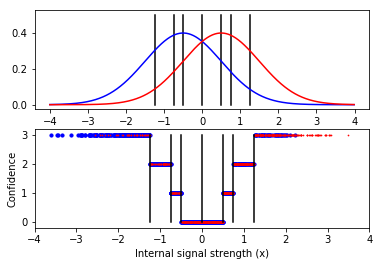

In [12]:
# Now is the fun part, and a demonstration of the whole reason to do generative modeling.

# The area under the Type 2 ROC (AUC2) is a measure of metacognitive sensitivity, i.e. how good an 
# observer is at assigning confidence to his/her answers in a meaningful way.
# Think of it this way: when the observer is correct, is he/she more likely to say "high confidence"?
# Right now, this is very true.  In fact, it is demonstrably true, by the first plot we made (reproduced below):

Figure1



Type 2 AUC without Type 2 noise =  0.636234671395
Type 2 AUC with noise =  0.588481992948


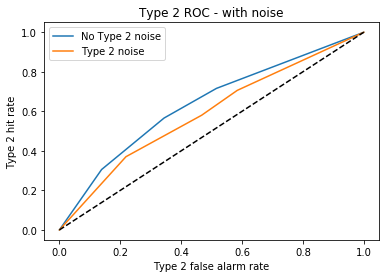

In [13]:
# See how the samples (dots) in the lower panel do not bleed over the confidence lines?  
# This means that confidence enjoys a deterministic relationship with internal signal strength (x).
# And of course it does.  This is how we defined it.

# But now let's break that, and see what happens to the Type 2 ROC and metacognitive sensitivity.
# To break the correspondence between confidence and accuracy, we want to add noise, or 'jitter', to the 
# confidence responses.  We can do this by assuming that there is additional noise that occurs after the Type 1
# judgment is made, because the internal representation may be noisy, such that by the time the Type 2 decision
# (i.e., confidence judgment) is made, there is more noise than there was previously.

# First, we define the additional Type 2 noise as normally distributed, with mean 0, and it's different on every trial.
sigma2 = .5
e2 = np.random.normal(0,sigma2,nsamples*2)

# Now re-do the confidence assignment, but with the noisy samples
# Assign confidence to each decision too
confidence2 = np.zeros((nsamples*2,))
for t in range(0,nsamples*2):
    for i in (0,3):
        if (np.abs(allSamples[t]) + e2[t]) > c2[2]:
            confidence2[t] = 3.0
        elif (np.abs(allSamples[t]) + e2[t]) > c2[1]:
            confidence2[t] = 2.0
        elif (np.abs(allSamples[t]) + e2[t]) > c2[0]:
            confidence2[t] = 1.0
        else:
            confidence2[t] = 0

# And now re-do the Type 2 ROC

HR22 = [1]
FAR22 = [1]
for i in range(0,4):
    hits2 = np.asarray(np.asarray(correct==1) & np.asarray(confidence2>i),dtype=np.float)
    fas2 = np.asarray(np.asarray(correct==0) & np.asarray(confidence2>i),dtype=np.float)
    HR22.append(sum(hits2) / ncorrect)
    FAR22.append(sum(fas2) / nincorrect)
HR22.append(0)
FAR22.append(0)

fig
plt.plot(FAR2,HR2)
plt.plot(FAR22,HR22)
plt.xlabel('Type 2 false alarm rate')
plt.ylabel('Type 2 hit rate')
plt.plot([0,1],[0,1],'k--')
plt.title('Type 2 ROC - with noise')
plt.legend(['No Type 2 noise','Type 2 noise'])

AUC22 = metrics.auc(FAR22,HR22)
print "Type 2 AUC without Type 2 noise = ", AUC2
print "Type 2 AUC with noise = ", AUC22




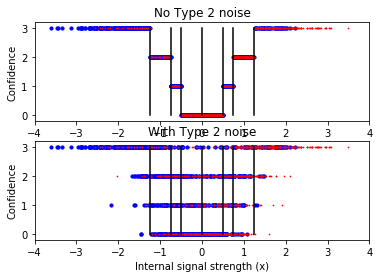

In [14]:
# See how the metacognitive sensitivity is reduced? Type 2 AUC is lower with additional Type 2 noise.
# We can see that this is because the correspondence between confidence and accuracy, or the correspondence
# between internal signal strength and confidence ratings, has been corrupted.  Let's plot the NOISY confidence
# ratings as a function of internal signal strength to see that.  See how the samples 'bleed over' the
# confidence criteria?

fig,
plt.subplot(2,1,1)
plt.plot([c,c],[0,3],'k')
for i in range(0,3):
    plt.plot([c2[i],c2[i]],[0,3],'k')
    plt.plot([-c2[i],-c2[i]],[0,3],'k')
plt.scatter(S1,confidence[:nsamples],10,'b')
plt.scatter(S2,confidence[nsamples:],.5,'r')
plt.xlim([-4,4])
plt.xlabel('Internal signal strength (x)')
plt.ylabel('Confidence')
plt.title('No Type 2 noise')

plt.subplot(2,1,2)
plt.plot([c,c],[0,3],'k')
for i in range(0,3):
    plt.plot([c2[i],c2[i]],[0,3],'k')
    plt.plot([-c2[i],-c2[i]],[0,3],'k')
plt.scatter(S1,confidence2[:nsamples],10,'b')
plt.scatter(S2,confidence2[nsamples:],.5,'r')
plt.xlim([-4,4])
plt.xlabel('Internal signal strength (x)')
plt.ylabel('Confidence')
plt.title('With Type 2 noise')


In [15]:
# What happens if you really crank up the noise?  What would really high Type 2 noise mean?

# Now that this is specified, you could fit the amount of Type 2 noise to subjects' behavior in an experiment.
# You could also assume that different manipulations introduce different amounts of Type 2 noise, and fit the 
# amount of noise in each condition.  

# Some examples of this idea are demonstrated in Rahnev et al., 2011.
# Although they used a slightly different modeling approach than discussed in our example here, the intent of the
# analysis, which relied on generative modeling, was the same.
# In that paper, the authors assumed noise (inattention) was Type 1 and not Type 2, and changed the means 
# and standard deviations of the generating distributions as a result.  Is that the same as the type of noise 
# that we assumed here?  
# Can you think of other sources of possible changes to processing as a result of TMS to visual cortex, or other 
# areas of the brain?  For example, Type 2 noise without Type 1 noise might be added by TMS not to visual
# areas, but to frontal areas, as done by McCurdy et al. (2010).

# What other ways might you be able to manipulate Type 1 sensitivity, or Type 2 sensitivity, or the relationship
# between them?  
# You could use this type of high-level model to test the effects of noninvasive brain stimulation of other ROIs,
# or of post-hoc trial splitting as a function of BOLD activity in a pre-determined ROI you think is involved.

# Could you extend this kind of high-level computational model to other experimental paradigms or questions?
# For example, a Monte Carlo simulation like this could be used for cue combination (Ernst & Banks, 2002) or 
# multisensory integration with causal inference (Kording et al., 2010; Peters et al., 2016).

# You could also hypothesize about how different psychiatric or neurological conditions might impact the measures
# you're simulating.

# What other ideas can you come up with?

